In [ ]:
## Group 16 - Manas Tota and Sridhar Munjam

In [1]:
from utils.data_loading import load_data, load_executions_info, load_subjects_info
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score
import os
from sklearn.preprocessing import LabelEncoder

In [2]:
#loading the subject info from the subject_info.csv
subjects_info = load_subjects_info()
subjects_info

,subject_id,age,gender,height,weight,dominant_hand,executions
0,s01,54,M,190,83,R,6
1,s02,31,M,171,71,R,9
2,s03,24,F,161,62,R,10
3,s04,51,M,174,60,R,10
4,s05,54,M,172,85,R,10
5,s06,53,M,179,110,R,10
6,s07,49,M,176,88,R,11
7,s08,63,M,165,89,R,9
8,s09,28,F,164,49,R,10
9,s10,66,F,165,72,R,10


In [3]:
# Filtering the required Data
filtered_data = subjects_info[['subject_id', 'age', 'gender']].copy(deep=True)
# To save this as a CSV
filtered_data.to_csv('output_csv/filtered_subjects_info.csv', index=False)

filtered_data

,subject_id,age,gender
0,s01,54,M
1,s02,31,M
2,s03,24,F
3,s04,51,M
4,s05,54,M
5,s06,53,M
6,s07,49,M
7,s08,63,M
8,s09,28,F
9,s10,66,F


In [4]:
# Create Lists Based on Gender
male_subjects = filtered_data[filtered_data['gender'] == 'M']['subject_id'].tolist()
female_subjects = filtered_data[filtered_data['gender'] == 'F']['subject_id'].tolist()

print("Male Subjects IDs:", male_subjects)
print("Female Subjects IDs:", female_subjects)

Male Subjects IDs: ['s01', 's02', 's04', 's05', 's06', 's07', 's08', 's11', 's12', 's13', 's14', 's16', 's18']
Female Subjects IDs: ['s03', 's09', 's10', 's15', 's17', 's19', 's20', 's21', 's22', 's23']


In [5]:
# Sort and Categorize by Age
def categorize_age(age):
    if age < 35:
        return 'emerging_adults'
    elif age <= 50:
        return 'established_adults'
    else:
        return 'old_or_retirement'

# Applying the categorization
filtered_data['age_group'] = filtered_data['age'].apply(categorize_age)

# Sorting by age logic and then grouping by age_group
sorted_age_groups = filtered_data.sort_values(by='age').groupby('age_group')['subject_id'].apply(list).to_dict()

# Extracting lists for each age group
emerging_adults_ids = sorted_age_groups.get('emerging_adults', [])
established_adults_ids = sorted_age_groups.get('established_adults', [])
old_or_retirement_ids = sorted_age_groups.get('old_or_retirement', [])


print("Emerging Adults IDs:", emerging_adults_ids)
print("Established Adults IDs:", established_adults_ids)
print("Old or Retirement Age Group IDs:", old_or_retirement_ids)

Emerging Adults IDs: ['s15', 's03', 's16', 's13', 's09', 's19', 's02', 's22', 's14']
Established Adults IDs: ['s12', 's23', 's07', 's11']
Old or Retirement Age Group IDs: ['s04', 's06', 's05', 's01', 's21', 's17', 's20', 's18', 's08', 's10']


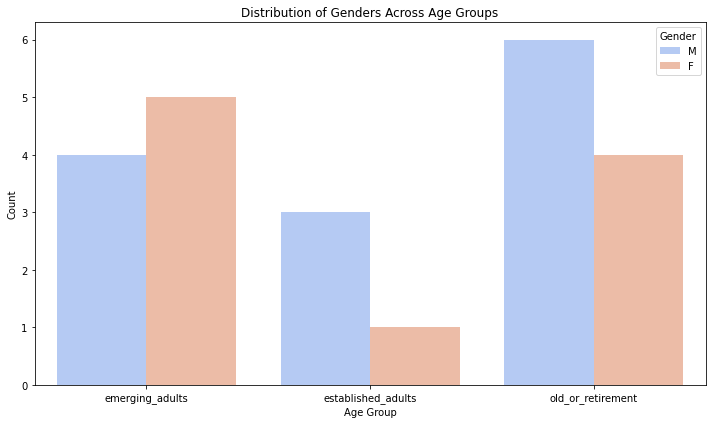

In [6]:
filtered_data['age_group'] = filtered_data['age'].apply(categorize_age)

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='age_group', hue='gender', data=filtered_data, palette='coolwarm', order=['emerging_adults', 'established_adults', 'old_or_retirement'])
plt.title('Distribution of Genders Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()

# Display the plot
plt.show()

In [7]:
# loading the executions info from executions_info.csv file
executions_info = load_executions_info()
executions_info

,execution_id,orientation,first_turn,second_turn
0,s01_01,back_inv,l,r
1,s01_02,back_inv,r,r
2,s01_03,back_inv,l,r
3,s01_04,back_inv,r,r
4,s01_05,back_inv,r,r
...,...,...,...,...
218,s23_05,back_inv,r,l
219,s23_06,back_inv,l,l
220,s23_07,back_inv,r,r
221,s23_08,back_inv,l,r


In [8]:
# Extract subject_id from execution_id
executions_info['subject_id'] = executions_info['execution_id'].apply(lambda x: x.split('_')[0])

# Merge executions_info with subjects_info to get gender and age for each execution
merged_data = pd.merge(executions_info, subjects_info, on='subject_id', how='left')

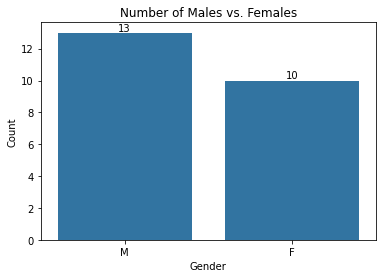

In [9]:
gender_count = subjects_info['gender'].value_counts()
ax = sns.barplot(x=gender_count.index, y=gender_count.values)
plt.title('Number of Males vs. Females')
plt.ylabel('Count')
plt.xlabel('Gender')


# Adding value labels directly above each bar
for index, label in enumerate(gender_count.index):
    count = gender_count[label]
    ax.text(index, count, str(count), color='black', ha="center", va='bottom', fontsize=10)

plt.show()

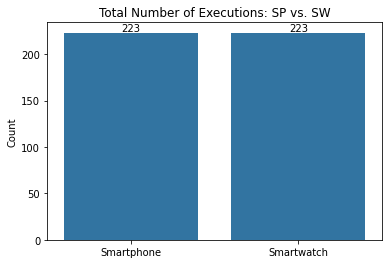

In [10]:
# Each execution_id has both 'sp' and 'sw'
total_executions = len(executions_info)   # Each id has both 'sp' and 'sw'
ax = sns.barplot(x=['Smartphone', 'Smartwatch'], y=[total_executions, total_executions])
plt.title('Total Number of Executions: SP vs. SW')
plt.ylabel('Count')

# Adding value labels directly above each bar
categories = ['Smartphone', 'Smartwatch']
for index, category in enumerate(categories):
    ax.text(index, total_executions, str(total_executions), color='black', ha="center", va='bottom', fontsize=10)

plt.show()

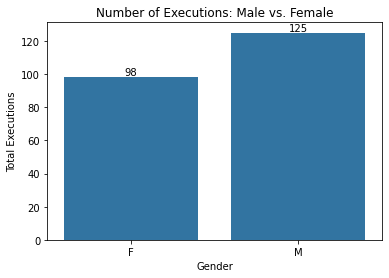

In [11]:
# Calculate executions by gender for both device types
gender_executions = merged_data.groupby('gender').size()
ax = sns.barplot(x=gender_executions.index, y=gender_executions.values)
plt.title('Number of Executions: Male vs. Female')
plt.ylabel('Total Executions')
plt.xlabel('Gender')

# Adding value labels directly above each bar
for index, value in enumerate(gender_executions.values):
    ax.text(index, value, str(value), color='black', ha="center", va='bottom')

plt.show()

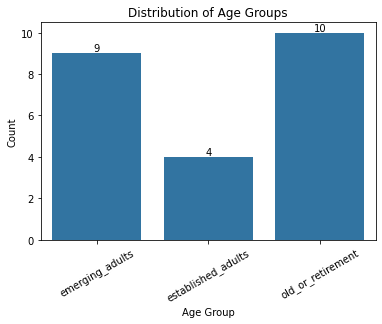

In [12]:
# Distribution of 'age_group' categorization in filtered_data
age_group_count = filtered_data['age_group'].value_counts().reindex(['emerging_adults', 'established_adults', 'old_or_retirement'])

# Plot with the specified order
ax = sns.barplot(x=age_group_count.index, y=age_group_count.values, order=['emerging_adults', 'established_adults', 'old_or_retirement'])
plt.title('Distribution of Age Groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.xticks(rotation=30)

# Adding value labels directly above each bar
for index, value in enumerate(age_group_count.values):
    ax.text(index, value, str(value), color='black', ha="center", va='bottom')

plt.show()

In [14]:
# loading the whole data with accelerometer and gryroscope values
data = load_data()
data

{'s01_01_sp':          x_acc     y_acc     z_acc    x_gyro    y_gyro    z_gyro  \
 0    -4.160221 -1.182952 -8.990732  0.002825 -0.013897 -0.032146   
 1    -4.184149 -1.190130 -9.014660  0.007101 -0.011453 -0.022983   
 2    -4.196114 -1.230808 -9.050552  0.010155 -0.012675 -0.012599   
 3    -4.244269 -1.254736 -9.105587  0.011377 -0.013897 -0.000382   
 4    -4.232305 -1.288236 -9.153444  0.011377 -0.016951  0.013133   
 ...        ...       ...       ...       ...       ...       ...   
 1346 -3.794119 -0.337687 -9.241979  0.002825 -0.005345  0.043065   
 1347 -3.801298 -0.352044 -9.225228  0.003436 -0.007177  0.043676   
 1348 -3.798905 -0.347258 -9.218050  0.004047 -0.009621  0.043065   
 1349 -3.782155 -0.344866 -9.215657  0.004047 -0.012675  0.042454   
 1350 -3.753441 -0.349651 -9.206086  0.003436 -0.013897  0.041232   
 
           timestamp   label  
 0     1657533977813  SEATED  
 1     1657533977864  SEATED  
 2     1657533977864  SEATED  
 3     1657533977865  SEATED  
 4

In [19]:
def train_and_evaluate_from_csv(csv_file_path):
    df = pd.read_csv(csv_file_path)
    
    # Separating features and labels
    X = df.iloc[:, :-1]  # Features: x_acc, y_acc, z_acc, x_gyro, y_gyro, z_gyro, timestamp
    y = df.iloc[:, -1]   # Labels

    # Encode string labels to integers for XGBoost classifier
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Spliting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Defining our classifiers
    classifiers = {
        "SVM": SVC(),
        "Random Forest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }
    
    # Train and evaluate classifiers
    for name, clf in classifiers.items():
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} accuracy: {accuracy:.2f}")

In [20]:
csv_file_path = 'DATA/s01/s01_01_sp.csv'  # just for testing
train_and_evaluate_from_csv(csv_file_path)

SVM accuracy: 0.96
Random Forest accuracy: 1.00
XGBoost accuracy: 0.99


In [25]:
def load_all_data_and_save(path='DATA', save_path='output_csv/the_final_data.csv'):
    data_frames = []
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".csv"):
                parts = file.split('_')
                # Making sure there are enough parts to proceed and also ending with either 'sp.csv' or 'sw.csv'
                if len(parts) < 3 or (parts[-1] not in ['sp.csv', 'sw.csv']):
                    continue
                
                subject_id = parts[0]
                # Joining based on underscore.
                executions = '_'.join(parts[1:-1])
                device_type = parts[-1].replace('.csv', '')  # Extracting 'sp' or 'sw'
                
                file_path = os.path.join(subdir, file)
                df = pd.read_csv(file_path)
                
                # Adding subject_id, executions, and device_type as columns
                df['subject_id'] = subject_id
                df['executions'] = executions
                df['device_type'] = device_type
                
                data_frames.append(df)
    
    combined_data = pd.concat(data_frames, ignore_index=True)
    
    #Save the combined data to a new CSV file
    combined_data.to_csv(save_path, index=False)
    print(f"Data saved to {save_path}")

In [26]:
load_all_data_and_save()

Data saved to output_csv/the_final_data.csv


In [42]:
#IMPORTANT CODE CELL

def train_and_evaluate(X, y):
    # Spliting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # train 80% and test 20%
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Encode string labels to integers for XGBoost classifier
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    classifiers = {
        "SVM": SVC(),
        "Random Forest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }
    
    for name, clf in classifiers.items():
        clf.fit(X_train_scaled, y_train_encoded)
        y_pred = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, y_pred)
        precision = precision_score(y_test_encoded, y_pred, average='macro')
        f1 = f1_score(y_test_encoded, y_pred, average='macro')
        print(f"{name}: Accuracy={accuracy:.2f}, Precision={precision:.2f}, F1 Score={f1:.2f}")


In [32]:
combined_data = pd.read_csv('output_csv/the_final_data.csv')
data_with_subject_info = pd.merge(combined_data, subjects_info, on='subject_id')

In [33]:
data_with_subject_info['age_group'] = data_with_subject_info['age'].apply(categorize_age)

In [34]:
def train_and_evaluate_on_filtered_data(filtered_data):
    X = filtered_data.drop(['subject_id', 'session', 'device_type', 'label', 'age', 'gender', 'height', 'weight', 'dominant_hand', 'executions', 'age_group'], axis=1, errors='ignore')
    y = filtered_data['label']
    
    train_and_evaluate(X, y)

In [39]:
# Filter by gender
for gender in ['M', 'F']:
    print(f"\n--- Evaluating for gender: {gender} ---")
    gender_data = data_with_subject_info[data_with_subject_info['gender'] == gender]
    train_and_evaluate_on_filtered_data(gender_data)


--- Evaluating for gender: M ---
SVM: Accuracy=0.80, Precision=0.82, F1 Score=0.76
Random Forest: Accuracy=0.95, Precision=0.96, F1 Score=0.95
XGBoost: Accuracy=0.87, Precision=0.88, F1 Score=0.86

--- Evaluating for gender: F ---
SVM: Accuracy=0.78, Precision=0.82, F1 Score=0.74
Random Forest: Accuracy=0.94, Precision=0.95, F1 Score=0.93
XGBoost: Accuracy=0.86, Precision=0.88, F1 Score=0.85


In [40]:
# Filter by age group
for age_group in ['emerging_adults', 'established_adults', 'old_or_retirement']:
    print(f"\n--- Evaluating for age group: {age_group} ---")
    age_group_data = data_with_subject_info[data_with_subject_info['age_group'] == age_group]
    train_and_evaluate_on_filtered_data(age_group_data)


--- Evaluating for age group: emerging_adults ---
SVM: Accuracy=0.79, Precision=0.81, F1 Score=0.75
Random Forest: Accuracy=0.94, Precision=0.95, F1 Score=0.94
XGBoost: Accuracy=0.88, Precision=0.90, F1 Score=0.87

--- Evaluating for age group: established_adults ---
SVM: Accuracy=0.83, Precision=0.84, F1 Score=0.81
Random Forest: Accuracy=0.96, Precision=0.97, F1 Score=0.96
XGBoost: Accuracy=0.94, Precision=0.95, F1 Score=0.94

--- Evaluating for age group: old_or_retirement ---
SVM: Accuracy=0.79, Precision=0.82, F1 Score=0.75
Random Forest: Accuracy=0.95, Precision=0.96, F1 Score=0.95
XGBoost: Accuracy=0.88, Precision=0.90, F1 Score=0.87


In [41]:
# Filter by device type
for device_type in ['sp', 'sw']:
    print(f"\n--- Evaluating for device type: {device_type} ---")
    device_data = data_with_subject_info[data_with_subject_info['device_type'] == device_type]
    train_and_evaluate_on_filtered_data(device_data)


--- Evaluating for device type: sp ---
SVM: Accuracy=0.80, Precision=0.82, F1 Score=0.76
Random Forest: Accuracy=0.93, Precision=0.95, F1 Score=0.93
XGBoost: Accuracy=0.87, Precision=0.88, F1 Score=0.86

--- Evaluating for device type: sw ---
SVM: Accuracy=0.81, Precision=0.83, F1 Score=0.78
Random Forest: Accuracy=0.94, Precision=0.95, F1 Score=0.94
XGBoost: Accuracy=0.88, Precision=0.89, F1 Score=0.87
